In [1]:
import pandas as pd
import numpy as np
from utils import *

In [64]:
# Retrieve Data
data = retrieve_data()
train = data['train'].copy()
test = data['test'].copy()
# The dependent feature that is to be predicted
y_feat = 'SalePrice'

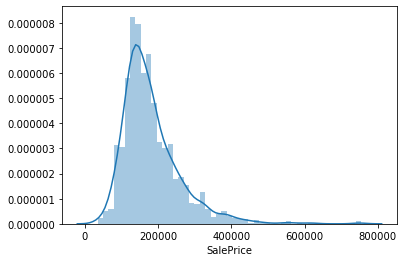

In [8]:
import seaborn as sns

# Check to see if the ditribution for of the SalePrice is close to Gaussian or not?

# histogram
sns.distplot(train[y_feat]);

The distribution is close enough to be gaussian yet it contains some outliers in it.

#### Note: Check all the unique categorical features in both training and testing datasets to see which features are missing in test dataset, This part might not be necessary but could be helpful.

## Encoding Categorical Features:
<p> 
    It would take great amount of time to go over the definitions of categorical features within the dataset and try to map them accordingly. The value of mapping for each unique value in a feature could be estimated based on its relation to the SalePrice. Meaning that the value with the highest SalePrice average should get a higher value in mapping. 
</p>
<p> 
    Yet we are interested in the relative values, so it would be logical to divide the the average of one unique value in a feature from the average of all of them:
</p>

##### Let's say that we have unique values A and B in the feature X
##### Now the average of SalePrice for value A (when X = A) is Ma and for B is Mb
##### The value that it is going to imputed for A is Ma / Ma + Mb and for B is Mb / Ma + Mb

In [65]:
# A dictionary of values corresponding to the categorical features within the dataset
cat_dics = {}
# List of all categorical features in the 
cat_feats = data['train_cat'].columns.to_list()
# Get the values for each of the categorical features
for feat in cat_feats:
    cat_dics[feat] = rank_categorical_values(train, feat)[0]

# There might be some missing values in the categorical features in the
# testing data, which will be treated as numerical and imputed with that
# respect.

In [66]:
cat_dics['Neighborhood']

{'CollgCr': 0.04304425976649378,
 'Veenker': 0.05191703153946601,
 'Crawfor': 0.04579673165007603,
 'NoRidge': 0.07290421209470918,
 'Mitchel': 0.03397825609535837,
 'Somerst': 0.049004977454523396,
 'NWAmes': 0.04110569276735894,
 'OldTown': 0.027880390973622476,
 'BrkSide': 0.027143022046897163,
 'Sawyer': 0.029743319483390717,
 'NridgHt': 0.06876761896720276,
 'NAmes': 0.031711944403308295,
 'SawyerW': 0.04056335615506725,
 'IDOTRR': 0.021770198380387268,
 'MeadowV': 0.021433761682225477,
 'Edwards': 0.027879173157315654,
 'Timber': 0.052672549788386036,
 'Gilbert': 0.041932902480024487,
 'StoneBr': 0.06751267852111145,
 'ClearCr': 0.04621870422721212,
 'NPkVill': 0.031026457909772254,
 'Blmngtn': 0.04237132883976904,
 'BrDale': 0.02272037253329444,
 'SWISU': 0.0310040439665444,
 'Blueste': 0.029897015116482902}

##### Better Neighborhoods have higher values.

## Imputing combined data:
<p>
   One of the concrete ways of imputing data is to combine both the test and train data and then impute all of the data at once and then rebreak into training and testing further on.   
</p>

<p><b>Note:</b> It is important to note that there will be categorical features in the test set which have Nan values but they did not have Nan values in training and hence there is no encoding value for them in the dictionary. These values will be treated as strictly numerical and will imputed using KNN algorithm. </p>

In [67]:
# Get the length of dataset so I can rebreak them after combining
train_len = train.shape[0]
test_len = test.shape[0]

# Get the column for the dependent data into a seprate variable
dep_col = train[y_feat]

# Drop the dependent column in train
train.drop([y_feat], axis=1 , inplace = True)
feat_cols = train.append(test) # Combine datasets
feat_cols.reset_index(inplace=True) # Reset Indexes
feat_cols.drop(['index', 'Id'], inplace=True, axis=1) # Drop Id and index columns

# Decode the categorical features in the combined dataset
for feat in cat_feats:
    feat_cols[feat] = impute_rank_weight(feat_cols[feat].copy(), cat_dics[feat])

# Getting the list of features with missing values in the dataset
missings = feat_cols.columns[feat_cols.isna().any()].tolist()

# Impute the missing categorical variables with KNNImputer
from sklearn.impute import KNNImputer

num = train_len + test_len // 3
imputer = KNNImputer(n_neighbors=num, weights="distance")
feat_cols[missings] = pd.DataFrame(imputer.fit_transform(feat_cols[missings]))

## Rebreaking into Test and Train data

In [68]:
# Now rebreak the data into train and test
imp_train = feat_cols[:train_len]
imp_train.loc[:, y_feat] = dep_col.copy()
imp_test = feat_cols[train_len:].reset_index()

/home/dmn/.local/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dmn/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [69]:
imp_train.corr()[y_feat].nlargest(18)[1:]

OverallQual     0.790982
Neighborhood    0.738630
GrLivArea       0.708624
ExterQual       0.690933
BsmtQual        0.681905
KitchenQual     0.675721
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
GarageFinish    0.553059
FireplaceQu     0.542181
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Foundation      0.506328
Name: SalePrice, dtype: float64

Some of the categorical features have high relations with the SalePrice column

## Feature Selection:
<p>
    When using Neural Networks, it is not that significant to choose features manually hence, we will work with some of the highly related features.
</p>

In [70]:
# Breaking the x and y splits:
# Finding the features
features = imp_train.corr()[y_feat].nlargest(26)[1:].keys().to_list()

# Training datasets
X = imp_train[features]
y = imp_train[y_feat]

# Testing datasets
X_test = imp_test[features]

# Normalized datasets:
# It makes more sense to use batchnormalization in NN instead
# of feeding normalized data into the model.
norm_X = normalize(X)
norm_y = normalize(y)
norm_X_test = normalize(X_test)

### Validation Set:
#### The data will be broken into ten patches for both evaluating during trainning as well as checking for overfitting after the training is done.

In [71]:
# Chunks of data used to check for overfitting
devs = [] # List that will save the chunks of data
dev_batch_size = int(imp_train.shape[0] * 0.3) # Size of each batch

for i in range(10):
    dev_data = imp_train.sample(n=dev_batch_size, random_state=i)
    dev_x = dev_data[features]
    dev_y = dev_data[y_feat]
    devs.append((dev_x, dev_y))

In [72]:
# Check to see if the imputation worked
True in X.isna().any()

False

In [75]:
type(devs[0])

tuple

## Training Models

In [44]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
# Softmax does not make sense, drop out and batchnormalization works
# For metrics, mse and msle should be considered
def build_model05():
  model = keras.Sequential([
    layers.InputLayer(input_shape=[len(X.keys())]),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(2048),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(16),
    layers.Dense(8),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)
    
  model.compile(loss='msle', optimizer=optimizer, metrics=['mae'])
  return model

model = build_model05()

In [51]:
# Validation functions
def validate():
    # Check to see if there have been an overfit or underfit
    for i in range(10):
        model.evaluate(devs[i][0], devs[i][1], batch_size=batch_size)

In [106]:
EPOCHS = 1500
batch_size = train_num // 5
patience = 115

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

In [107]:
model.fit(X, y, epochs=EPOCHS, verbose=0, validation_split=devs[3], callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.3945,  mae:119467.0703,  val_loss:4.0050,  val_mae:1011793.1250,  
....................................................................................................
Epoch: 100, loss:0.0281,  mae:23129.1562,  val_loss:0.0310,  val_mae:21840.4668,  
....................................................................................................
Epoch: 200, loss:0.0210,  mae:20214.6641,  val_loss:0.0302,  val_mae:21501.1660,  
....................................................................................................
Epoch: 300, loss:0.0162,  mae:17182.3887,  val_loss:0.0272,  val_mae:20217.6172,  
......................................................................

#### Since the evaluation data passed to the model is not trained and model never sees it, it would make sense to train the whole data on all of the chunks that is used for validation

In [95]:
# Pridctions
pred_y = pd.DataFrame(model.predict(X_test, batch_size=20, steps=73, verbose=0))[0]

# It would make sense to convert all of the data to int instead of float since there no floats in trainig.
modified = quantize(pred_y)

# Check the preditions
modified[:10]

In [97]:
output = pd.DataFrame({'Id': test.Id,
                      'SalePrice': modified})
output.to_csv('submission.csv', index=False)

In [40]:
# Save the model given that the score is good
model.save_weights('./weights/3-015095')